# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os


# Dataset Collection

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shuvamkundu123","key":"a4913938f0422b13c82357ee4c4caf30"}'}

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d splcher/animefacedataset

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 98% 385M/395M [00:01<00:00, 426MB/s]
100% 395M/395M [00:01<00:00, 357MB/s]


In [5]:
!unzip animefacedataset.zip -d animefacedataset

Streaming output truncated to the last 5000 lines.
  inflating: animefacedataset/images/62764_2019.jpg  
  inflating: animefacedataset/images/62765_2019.jpg  
  inflating: animefacedataset/images/62766_2019.jpg  
  inflating: animefacedataset/images/62767_2019.jpg  
  inflating: animefacedataset/images/62768_2019.jpg  
  inflating: animefacedataset/images/62769_2019.jpg  
  inflating: animefacedataset/images/6276_2003.jpg  
  inflating: animefacedataset/images/62770_2019.jpg  
  inflating: animefacedataset/images/62771_2019.jpg  
  inflating: animefacedataset/images/62772_2019.jpg  
  inflating: animefacedataset/images/62773_2019.jpg  
  inflating: animefacedataset/images/62774_2019.jpg  
  inflating: animefacedataset/images/62775_2019.jpg  
  inflating: animefacedataset/images/62776_2019.jpg  
  inflating: animefacedataset/images/62777_2019.jpg  
  inflating: animefacedataset/images/62778_2019.jpg  
  inflating: animefacedataset/images/62779_2019.jpg  
  inflating: animefacedataset/im

In [6]:
!ls animefacedataset
!ls animefacedataset/some_subfolder

images
ls: cannot access 'animefacedataset/some_subfolder': No such file or directory


In [7]:
!ls

animefacedataset  animefacedataset.zip	sample_data


In [8]:
image_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])

In [9]:
batch_size = 128
dataset = ImageFolder("animefacedataset",transform=image_transform)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=2)

In [10]:
real_images_batch, _ = next(iter(dataloader))

print(f"Shape of one batch of real images: {real_images_batch.shape}")
print(f"Pixel value minimum: {real_images_batch.min()}")
print(f"Pixel value maximum: {real_images_batch.max()}")

Shape of one batch of real images: torch.Size([128, 3, 64, 64])
Pixel value minimum: -1.0
Pixel value maximum: 1.0


In [11]:
images_dir = r'animefacedataset/images'
image_paths=[]

for file in os.listdir(images_dir):
    if file.endswith(".png") or file.endswith(".jpg"):
        image_paths.append(os.path.join(images_dir,file))

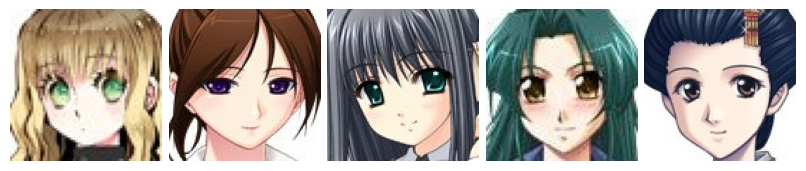

In [12]:
import random
from matplotlib.image import imread
fig,axes = plt.subplots(1,5,figsize=(8,2.5))

for j,ax in enumerate(axes):
    random_img = random.choice(image_paths)
    img = imread(random_img)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()

# Build Model

In [19]:
class Generator(nn.Module):
    def __init__(self,latent_dim=100):
        super().__init__()
        self.linear =nn.Sequential(
            nn.Linear(latent_dim,512*8*8),
            nn.BatchNorm1d(512*8*8),
            nn.ReLU(),
        )
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(512,256,kernel_size=5,stride=2,padding =2,output_padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256,128,kernel_size=5,stride=2,padding =2,output_padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,kernel_size=5,stride=2,padding =2,output_padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,3,kernel_size=5,stride=1,padding=2,bias=False),
            nn.Tanh()
        )
    def forward(self,x):
        x = self.linear(x)
        x = x.view(-1,512,8,8)
        return self.sequential(x)

In [20]:
class Discriminator(nn.Module):
    def __init__(self,input_size=3):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.sequential(x)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D = Discriminator().to(device)
G = Generator().to(device)

In [22]:
d_optimizer = optim.Adam(D.parameters(), lr=1e-4,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(), lr=1e-4,betas=(0.5,0.999))
loss_function = nn.BCELoss()
epochs = 50

In [23]:
def plot_images(generated_images):
    img = generated_images.detach().cpu().numpy()
    img = ((img +1)*127.5).astype(np.uint8)
    img = np.transpose(img,(0,2,3,1))

    fig,axes = plt.subplots(1,5,figsize=(10,4))
    for i in range(5):
        axes[i].imshow(img[i])
        axes[i].axis('off')
    plt.show()

Epoch : 10, G_loss : 1.8323, D_loss : 0.7615


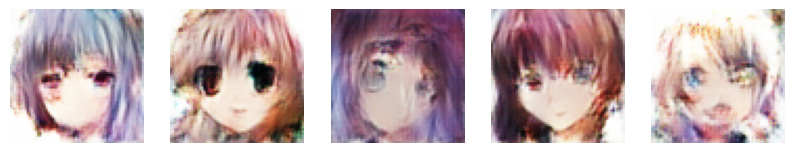

Epoch : 20, G_loss : 1.3263, D_loss : 1.0369


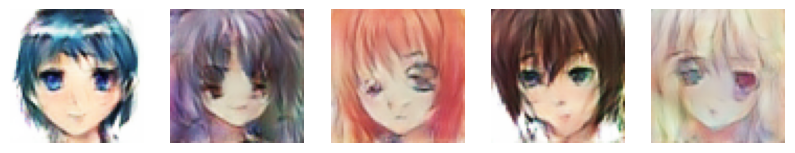

Epoch : 30, G_loss : 1.2913, D_loss : 1.0580


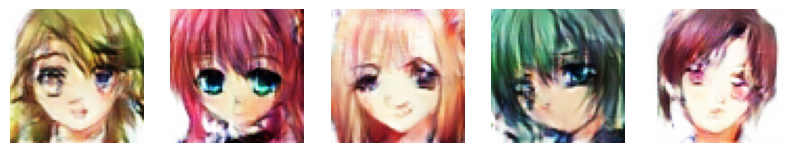

Epoch : 40, G_loss : 1.3384, D_loss : 1.0352


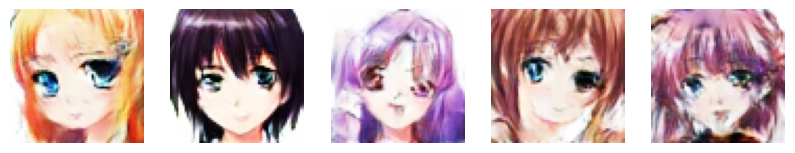

Epoch : 50, G_loss : 1.4293, D_loss : 0.9898


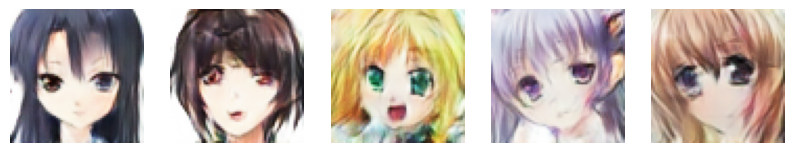

In [24]:
history = []
batch_size = 128
for epoch in range(1, epochs+1):
    g_losses = []
    d_losses = []
    for batch_idx , (real_images,_) in enumerate(dataloader):

        idx = np.random.randint(0, real_images.shape[0], batch_size)
        real_batch = real_images[idx].to(device)

        # labels
        real_labels = torch.ones((batch_size, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # Train Discriminator
        z = torch.randn(batch_size, 100, device=device)
        fake_batch = G(z)
        D_real = D(real_batch)
        D_fake = D(fake_batch.detach())

        d_loss = loss_function(D_real,real_labels) + loss_function(D_fake,fake_labels)

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, 100,device=device)
        fake_batch = G(z)
        D_fake = D(fake_batch)
        g_loss = loss_function(D_fake,real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()


        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    report = {
        "epoch":epoch,
        "g_loss" : float(np.mean(g_losses)),
        "d_loss" : float(np.mean(d_losses))
    }
    history.append(report)

    if epoch % 10 == 0:
        print(f"Epoch : {epoch}, G_loss : {report['g_loss'] :.4f}, D_loss : {report['d_loss']:.4f}")
        with torch.no_grad():
            z = torch.randn(5,100, device=device)
            fake_samples = G(z).detach()
            plot_images(fake_samples)


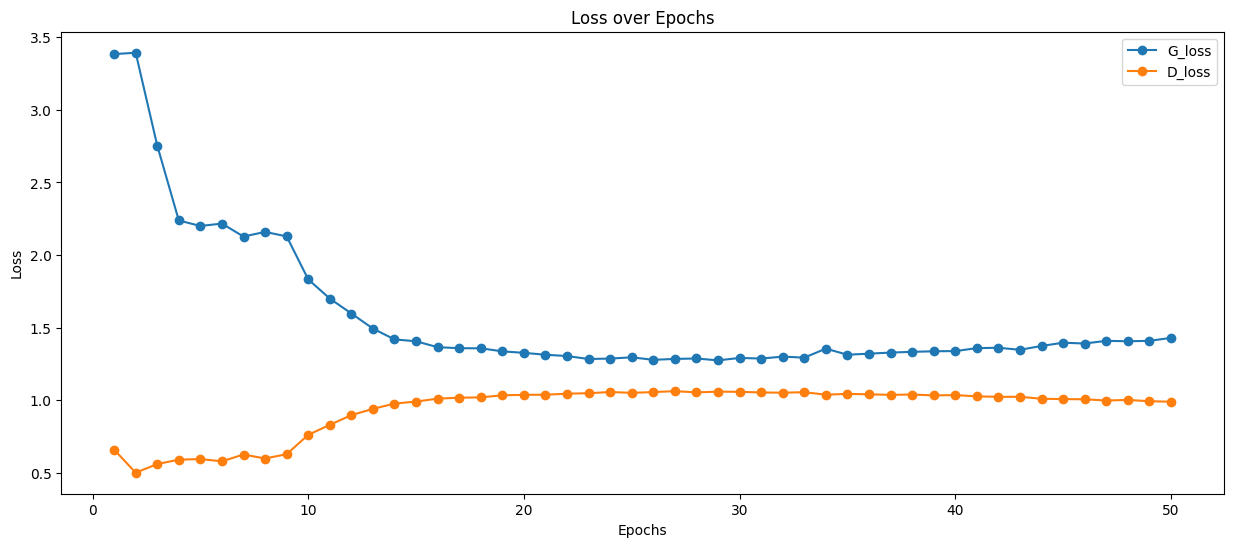

In [25]:
plt.figure(figsize=(15,6))
plt.plot(range(1,51),[r['g_loss'] for r in history],label ='G_loss',marker ='o')
plt.plot(range(1,51),[r['d_loss'] for r in history],label ='D_loss',marker ='o')
plt.title("Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generated Images

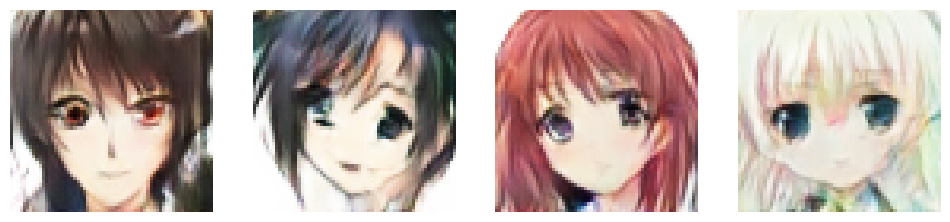

In [48]:
noise = torch.randn(4,100,device=device)
generated_images = G(noise)
img = generated_images.detach().cpu().numpy()
img = ((img +1)*127.5).astype(np.uint8)
img = np.transpose(img,(0,2,3,1))

fig,axes = plt.subplots(1,4,figsize=(12,7))
for i in range(4):
    axes[i].imshow(img[i])
    axes[i].axis('off')
plt.show()

# FID Score

In [50]:
import os
import torchvision.utils as vutils

os.makedirs("generated", exist_ok=True)

z = torch.randn(1000, 100, device=device)
fake_images = G(z)

# Save images
for i in range(fake_images.size(0)):
    vutils.save_image(fake_images[i], f"generated/{i}.png", normalize=True)

In [51]:
!pip install torch-fidelity

In [56]:
from PIL import Image
import os

# Create a directory to store resized images
resized_images_dir = "resized_animefacedataset_images"
os.makedirs(resized_images_dir, exist_ok=True)

# Get the list of image paths from the original dataset
images_dir = r'animefacedataset/images'
image_paths = []
for file in os.listdir(images_dir):
    if file.endswith(".png") or file.endswith(".jpg"):
        image_paths.append(os.path.join(images_dir, file))

# Resize and save each image
target_size = (64, 64)
for img_path in image_paths:
    try:
        img = Image.open(img_path).convert("RGB") # Ensure image is in RGB format
        img_resized = img.resize(target_size)
        save_path = os.path.join(resized_images_dir, os.path.basename(img_path))
        img_resized.save(save_path)
    except Exception as e:
        print(f"Could not process image {img_path}: {e}")

print(f"Resized and saved {len(image_paths)} images to {resized_images_dir}")

Resized and saved 63565 images to resized_animefacedataset_images


In [57]:
from torch_fidelity import calculate_metrics
import torchvision.transforms as transforms

# Reuse the transformation defined earlier
image_transform_fid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])


metrics = calculate_metrics(
    input1='resized_animefacedataset_images/', # Use the directory with resized images
    input2='generated/',
    fid=True,
    cuda=torch.cuda.is_available(),
    input1_cached=True, # Cache the statistics for the real images
    input1_transform=image_transform_fid # Apply the transformation to the real images
)

print("FID:", metrics['frechet_inception_distance'])

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "resized_animefacedataset_images/" with extensions png,jpg,jpeg
Found 63565 samples, some are lossy-compressed - this may affect metrics
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "generated/" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples


FID: 76.44350625210635


Frechet Inception Distance: 76.44350625210635


In [58]:
torch.save(D.state_dict,"D.pt")
torch.save(G.state_dict,"G.pt")